In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# feature importance 
def vis_feature_importances_(est, X_train):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,4))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()

## Data Load

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# train = pd.read_csv('/content/drive/MyDrive/work/input/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/work/input/test.csv')
# building_info = pd.read_csv('/content/drive/MyDrive/work/input/building_info.csv')
# submission = pd.read_csv('/content/drive/MyDrive/work/input/sample_submission.csv')
# train.shape, test.shape, building_info.shape, submission.shape

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
building_info = pd.read_csv('input/building_info.csv')
submission = pd.read_csv('input/sample_submission.csv')
train.shape, test.shape, building_info.shape, submission.shape

((204000, 10), (16800, 7), (100, 7), (16800, 2))

## Train Data Pre-Processing

In [4]:
# 빌딩 데이터 정리
## null 처리
building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].str.replace('-','0').astype(float)
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].str.replace('-','0').astype(float)
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].str.replace('-','0').astype(float)

In [5]:
# 정리된 빌딩과 merge
train = train.merge(building_info, on='건물번호')
test = test.merge(building_info, on='건물번호')

In [6]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

In [7]:
# 요일
train['weekday'] =  pd.to_datetime(train['일시'].str[:8]).dt.weekday
test['weekday'] =  pd.to_datetime(test['일시'].str[:8]).dt.weekday

In [8]:
target_encoding = train.groupby(['건물유형']).agg({'전력소비량(kWh)':['min', 'mean','max']}).reset_index()
target_encoding.columns = ['건물유형', 'khw_min', 'khw_mean', 'khw_max']
train = train.merge(target_encoding, on=['건물유형'], how='left')
test = test.merge(target_encoding, on=['건물유형'], how='left')

In [9]:
train['냉방비율'] = ((train['냉방면적(m2)'] / train['연면적(m2)'])*100 ).astype(int)
test['냉방비율'] = ((test['냉방면적(m2)'] / test['연면적(m2)'])*100 ).astype(int)

train = train.drop(columns=['연면적(m2)','냉방면적(m2)'])
test = test.drop(columns=['연면적(m2)','냉방면적(m2)'])

In [10]:
#결측값을 0으로 채웁니다
train = train.fillna(0)
test = test.fillna(0)

In [11]:
# train['풍속(m/s)'] = 0
# train.loc[train['건물유형'].isin(['호텔및리조트','백화점및아울렛']), '풍속(m/s)'] = 0

In [12]:
train.drop('풍속(m/s)', axis=1, inplace=True)
test.drop('풍속(m/s)', axis=1, inplace=True)

In [13]:
# outlier 제거 
train = train[train['전력소비량(kWh)'] > 1]

In [14]:
train_x = train.drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
train_y = train['전력소비량(kWh)']

test_x = test.drop(columns=['num_date_time', '일시'])

In [15]:
#결측값을 0으로 채웁니다
train_x = train_x.fillna(0)
train_y = train_y.fillna(0)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_x , train_y ,test_size=0.2, shuffle=True, random_state=42, stratify=train_x['건물번호'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163198, 16) (40800, 16) (163198,) (40800,)


## Regression Model Fit

,건물유형,유형별_score
0,건물기타,0.0484948


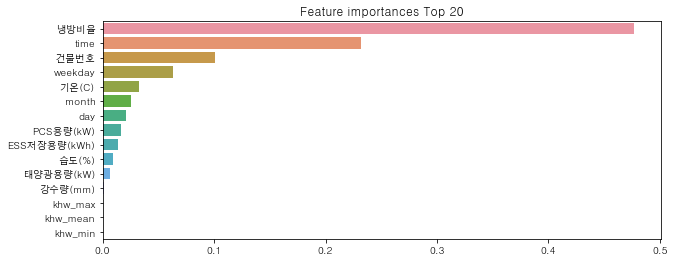

,건물유형,유형별_score
0,공공,0.0373652


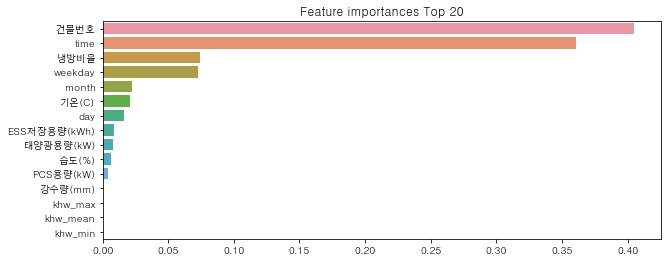

,건물유형,유형별_score
0,대학교,0.0337252


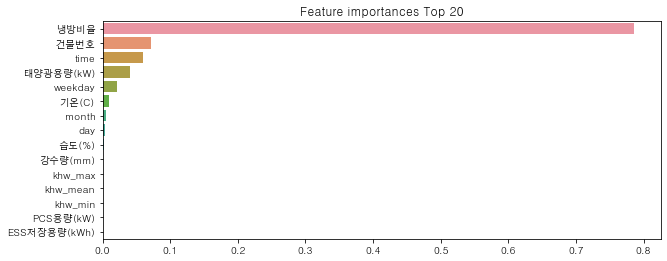

,건물유형,유형별_score
0,데이터센터,0.00364542


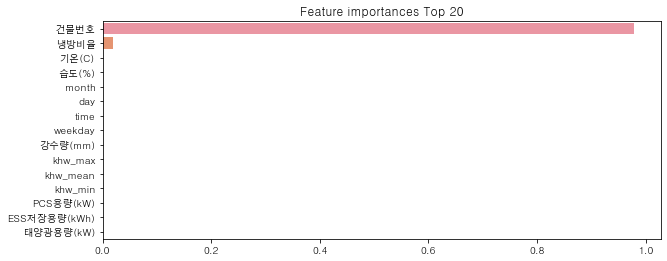

,건물유형,유형별_score
0,백화점및아울렛,0.053971


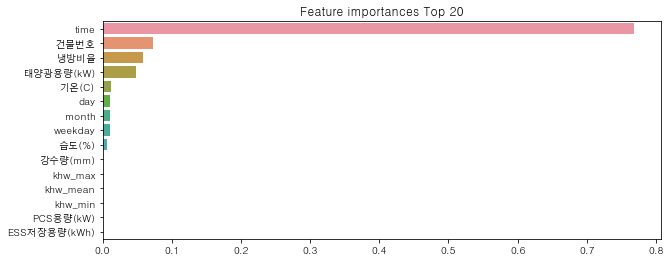

,건물유형,유형별_score
0,병원,0.0256067


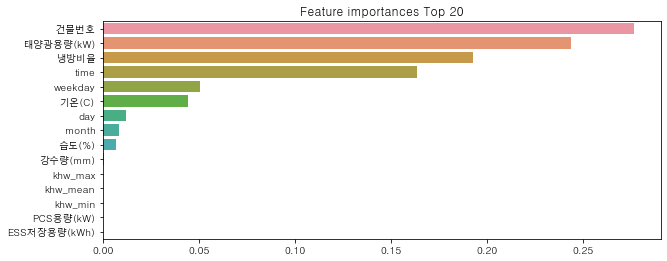

,건물유형,유형별_score
0,상용,0.0394318


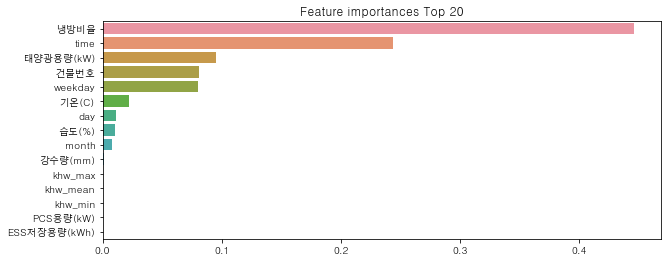

,건물유형,유형별_score
0,아파트,0.0387732


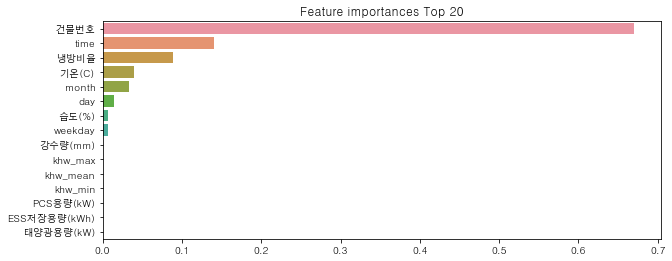

,건물유형,유형별_score
0,연구소,0.0315973


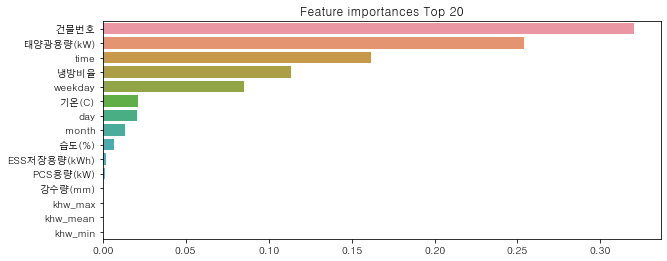

,건물유형,유형별_score
0,지식산업센터,0.0381446


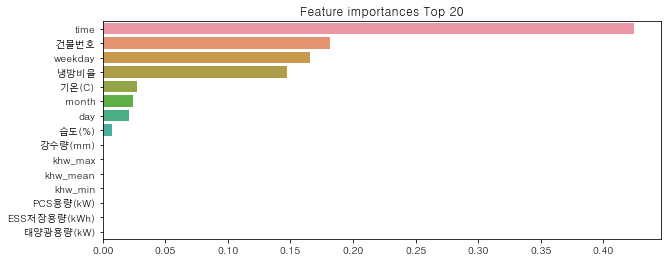

,건물유형,유형별_score
0,할인마트,0.0475801


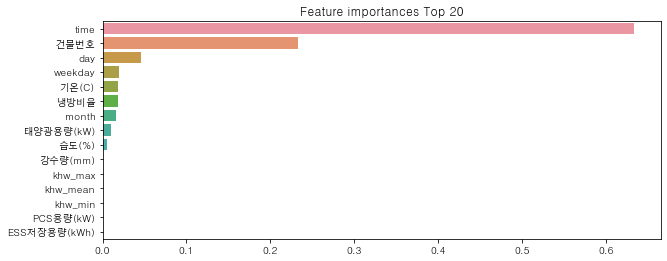

,건물유형,유형별_score
0,호텔및리조트,0.0539197


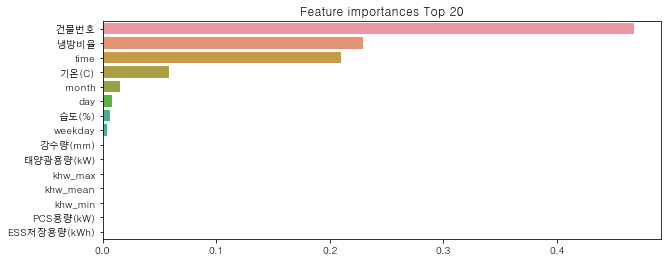

Wall time: 53.5 s


In [17]:
%%time 
metrics_type = pd.DataFrame()
for i in train['건물유형'].unique():
    temp_X_train = X_train[X_train['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, mean_absolute_percentage_error(temp_y_test, y_preds)]).T
    temp.columns = ['건물유형', '유형별_score']
    metrics_type = metrics_type.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    

,건물번호,건물별_score
0,1.0,0.052569


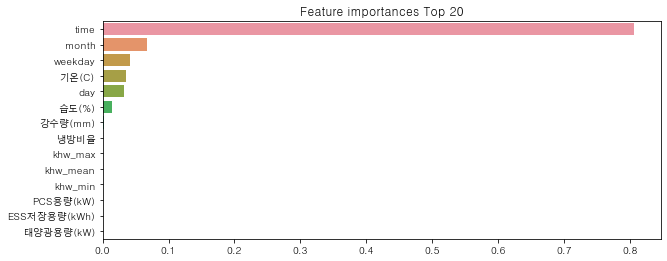

,건물번호,건물별_score
0,2.0,0.05814


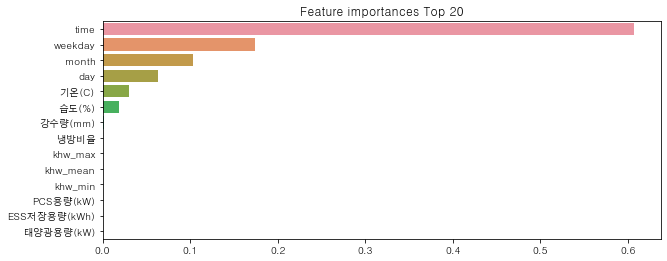

,건물번호,건물별_score
0,3.0,0.078324


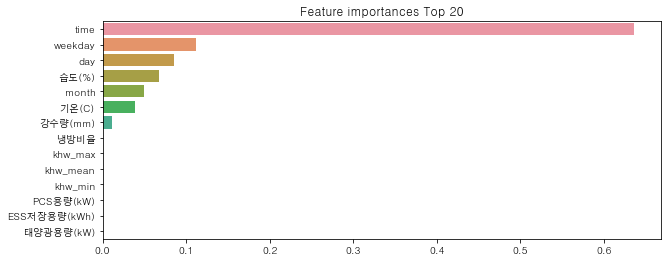

,건물번호,건물별_score
0,4.0,0.03534


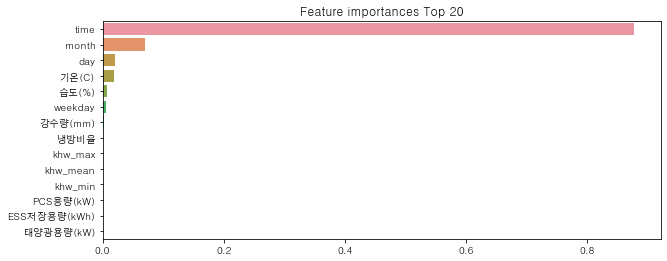

,건물번호,건물별_score
0,5.0,0.043118


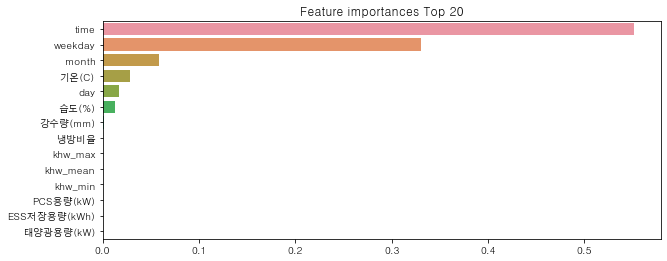

,건물번호,건물별_score
0,6.0,0.03292


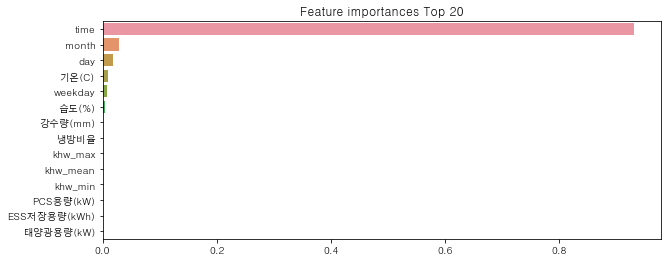

,건물번호,건물별_score
0,7.0,0.055474


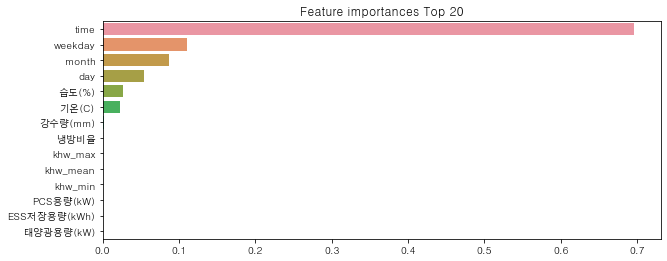

,건물번호,건물별_score
0,8.0,0.04216


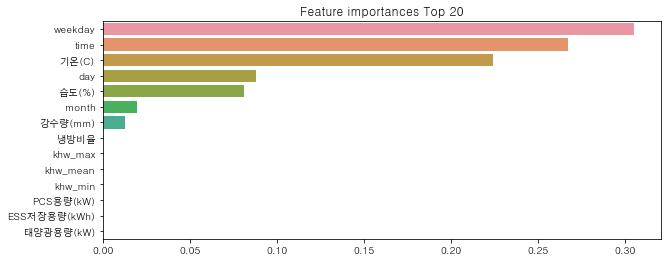

,건물번호,건물별_score
0,9.0,0.030712


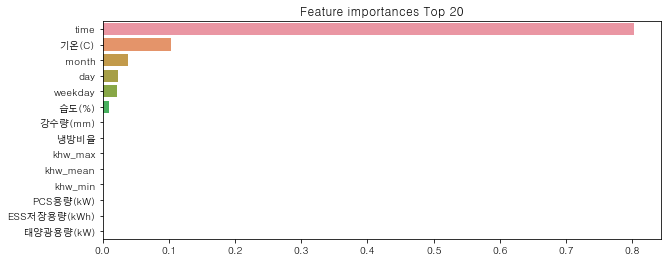

,건물번호,건물별_score
0,10.0,0.030779


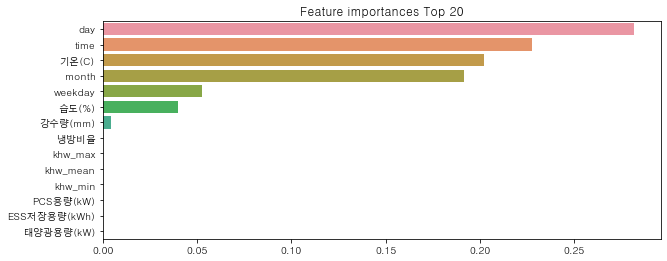

,건물번호,건물별_score
0,11.0,0.031347


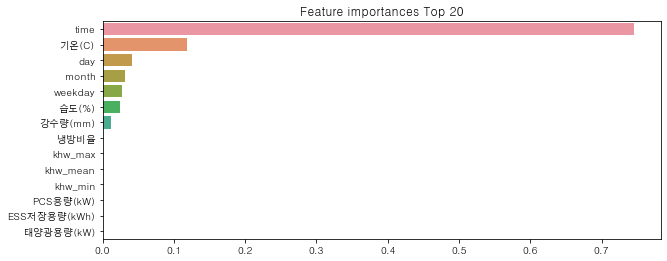

,건물번호,건물별_score
0,12.0,0.030711


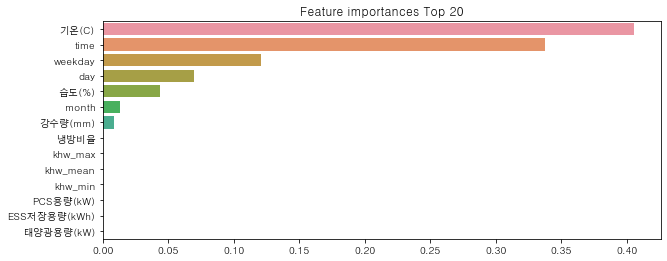

,건물번호,건물별_score
0,13.0,0.042164


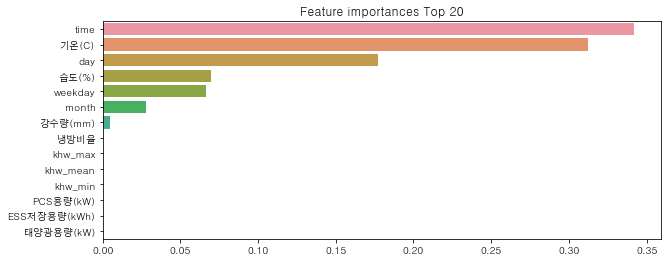

,건물번호,건물별_score
0,14.0,0.108939


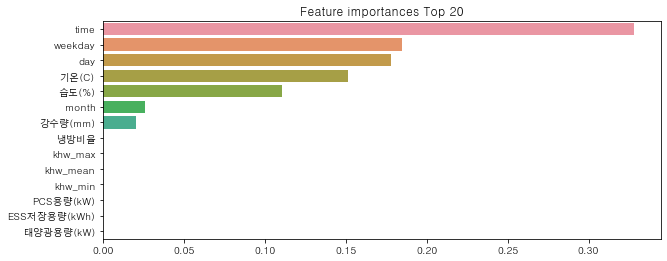

,건물번호,건물별_score
0,15.0,0.022921


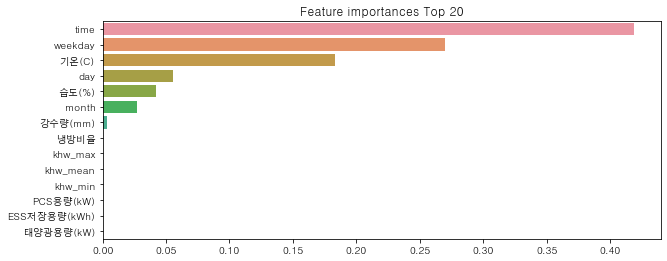

,건물번호,건물별_score
0,16.0,0.039582


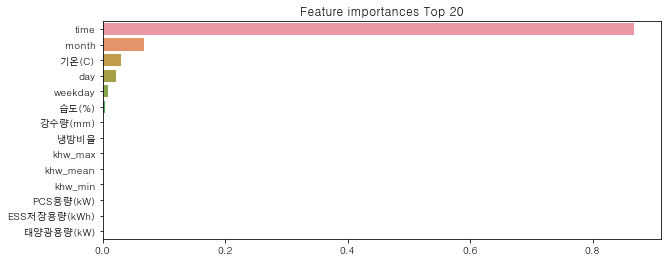

,건물번호,건물별_score
0,17.0,0.046929


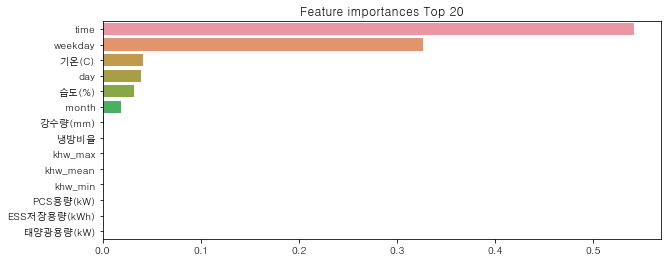

,건물번호,건물별_score
0,18.0,0.040328


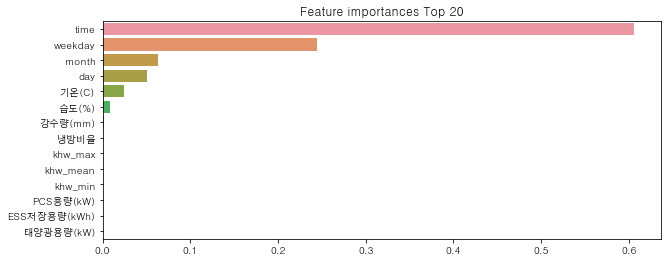

,건물번호,건물별_score
0,19.0,0.037496


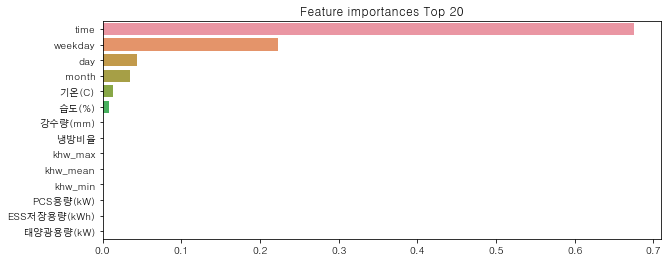

,건물번호,건물별_score
0,20.0,0.042081


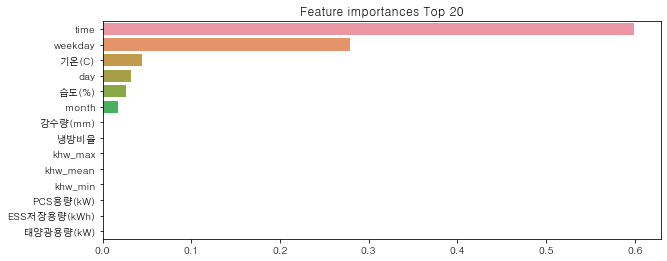

,건물번호,건물별_score
0,21.0,0.042056


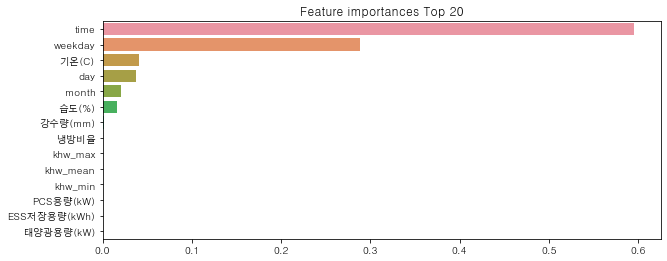

,건물번호,건물별_score
0,22.0,0.032507


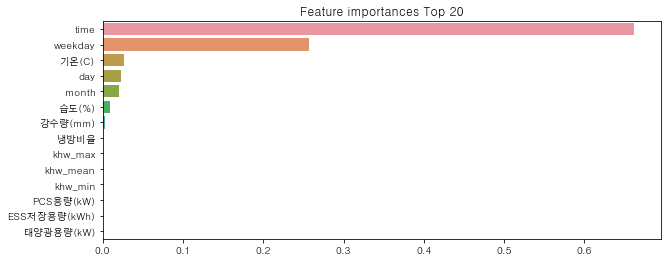

,건물번호,건물별_score
0,23.0,0.014277


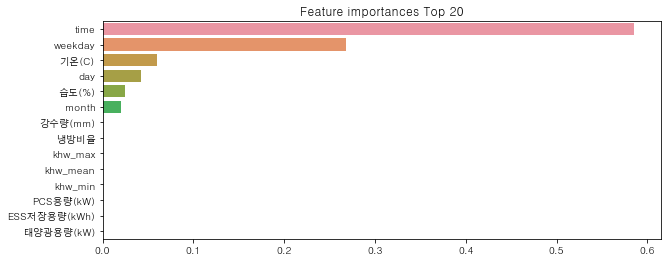

,건물번호,건물별_score
0,24.0,0.028521


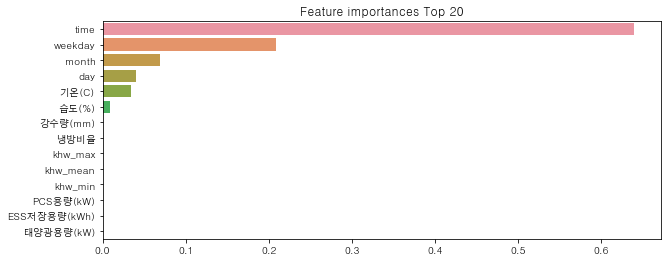

,건물번호,건물별_score
0,25.0,0.027125


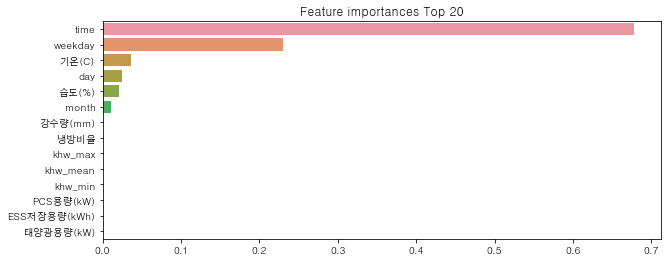

,건물번호,건물별_score
0,26.0,0.024628


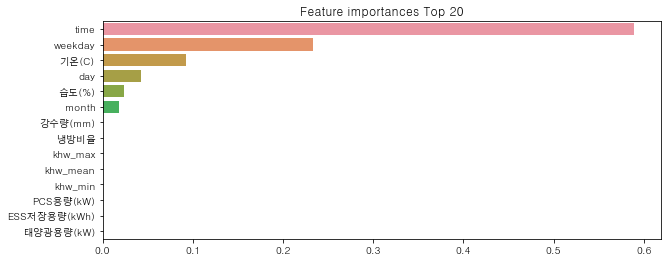

,건물번호,건물별_score
0,27.0,0.015862


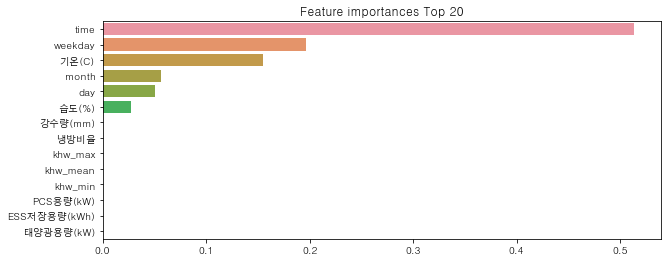

,건물번호,건물별_score
0,28.0,0.046417


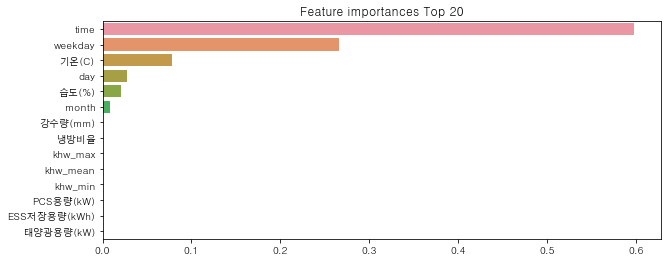

,건물번호,건물별_score
0,29.0,0.030425


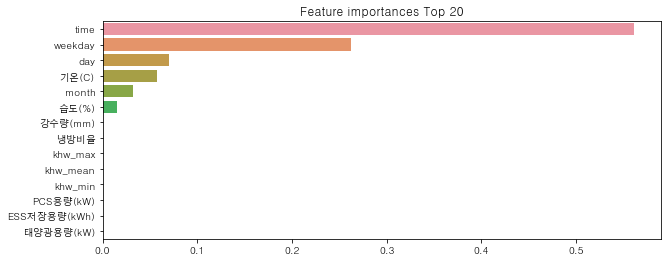

,건물번호,건물별_score
0,30.0,0.060474


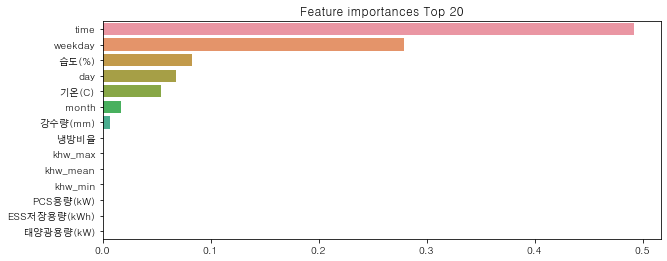

,건물번호,건물별_score
0,31.0,0.035705


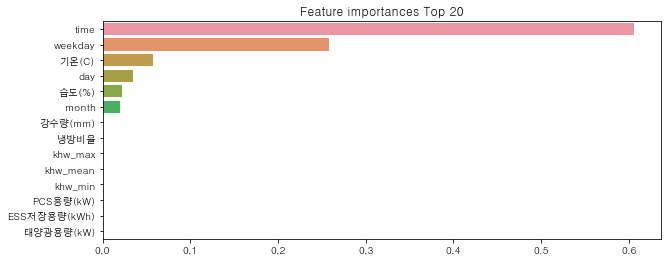

,건물번호,건물별_score
0,32.0,0.002697


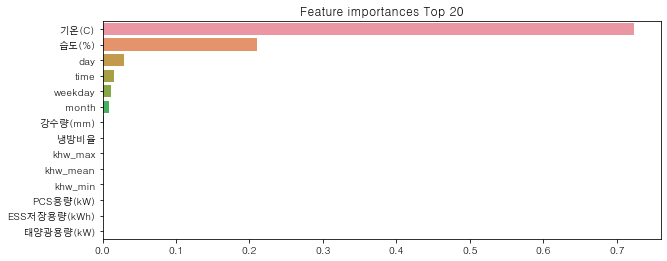

,건물번호,건물별_score
0,33.0,0.002584


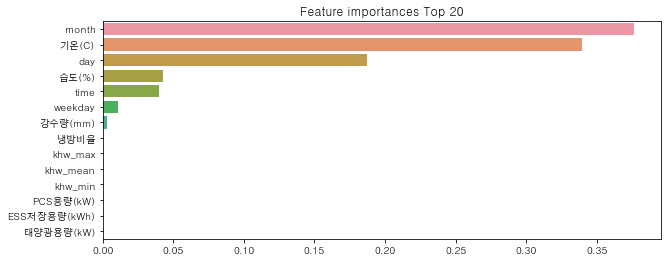

,건물번호,건물별_score
0,34.0,0.005332


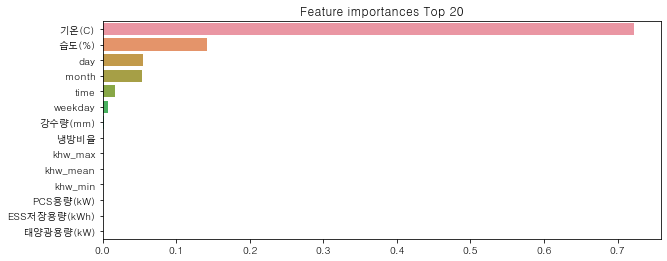

,건물번호,건물별_score
0,35.0,0.003301


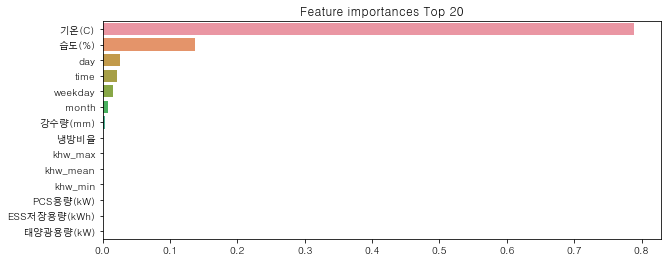

,건물번호,건물별_score
0,36.0,0.004286


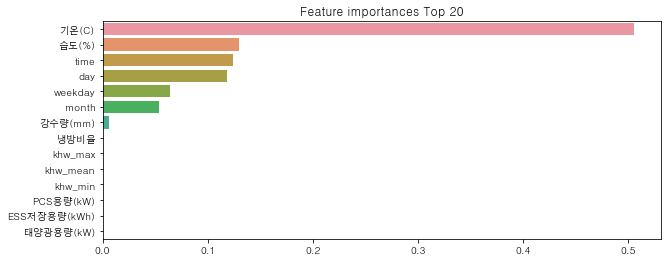

,건물번호,건물별_score
0,37.0,0.034147


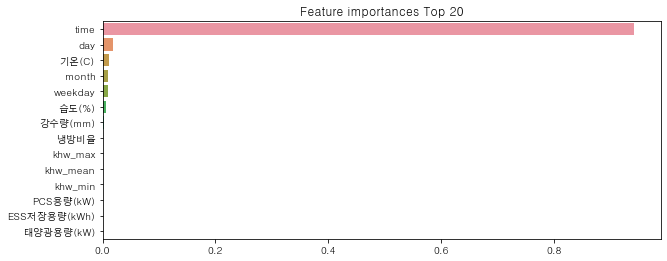

,건물번호,건물별_score
0,38.0,0.060292


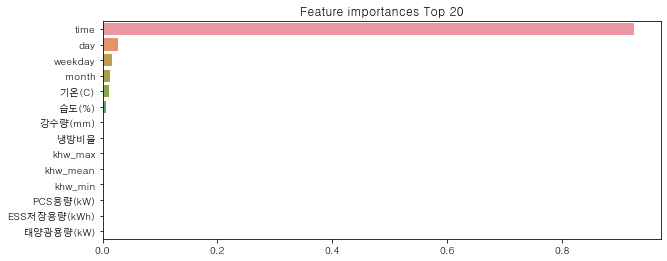

,건물번호,건물별_score
0,39.0,0.040761


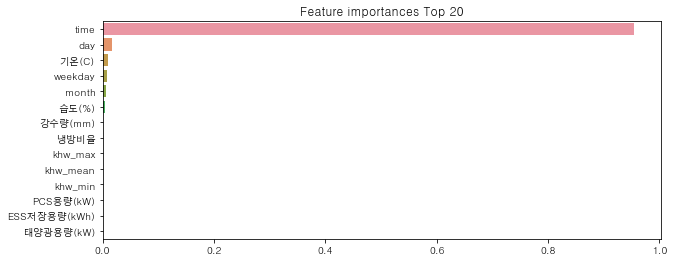

,건물번호,건물별_score
0,40.0,0.094696


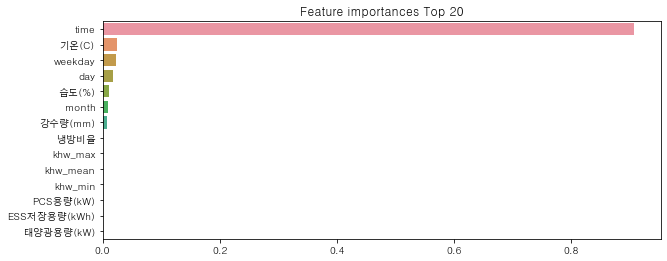

,건물번호,건물별_score
0,41.0,0.050583


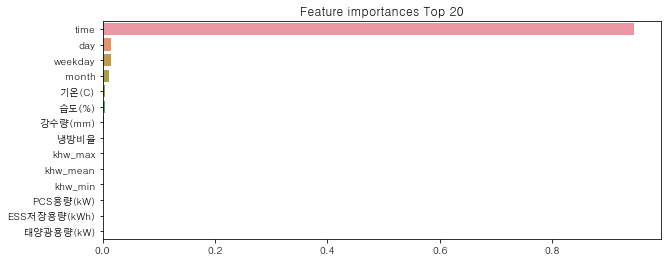

,건물번호,건물별_score
0,42.0,0.050816


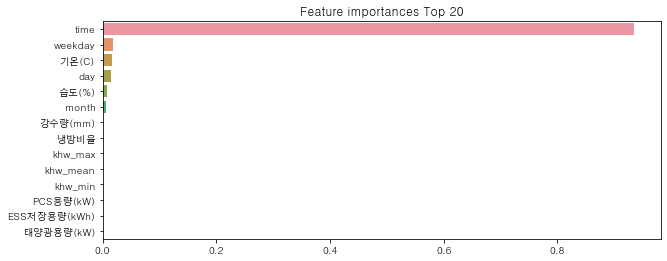

,건물번호,건물별_score
0,43.0,0.043337


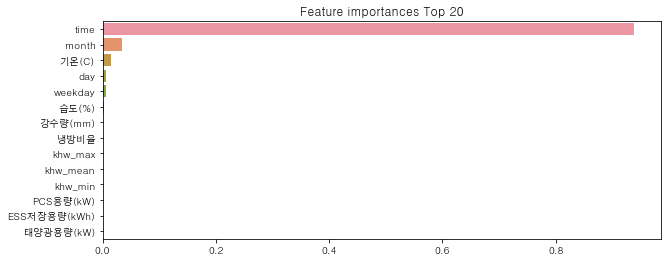

,건물번호,건물별_score
0,44.0,0.026515


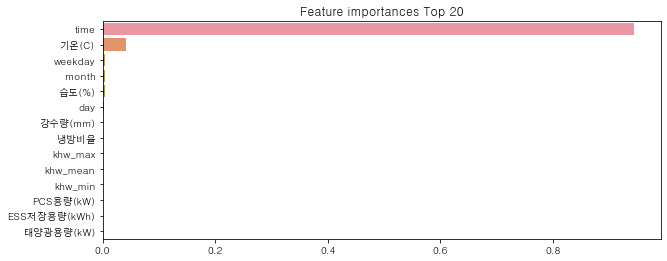

,건물번호,건물별_score
0,45.0,0.020436


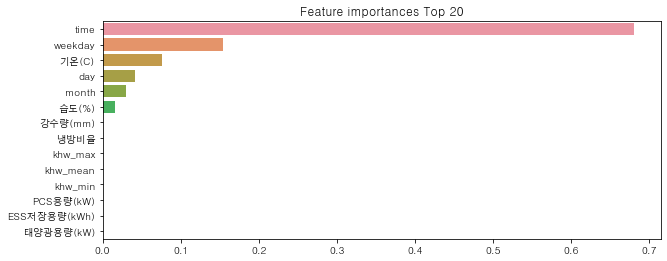

,건물번호,건물별_score
0,46.0,0.034686


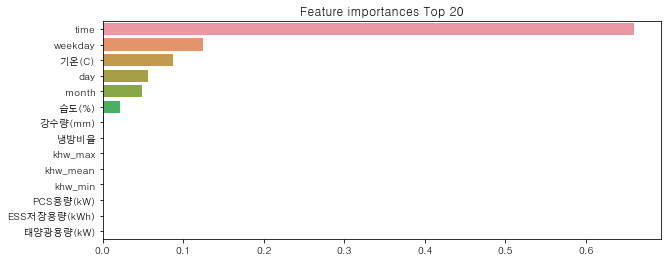

,건물번호,건물별_score
0,47.0,0.02297


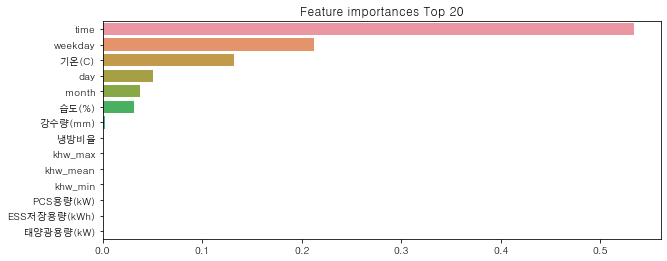

,건물번호,건물별_score
0,48.0,0.024539


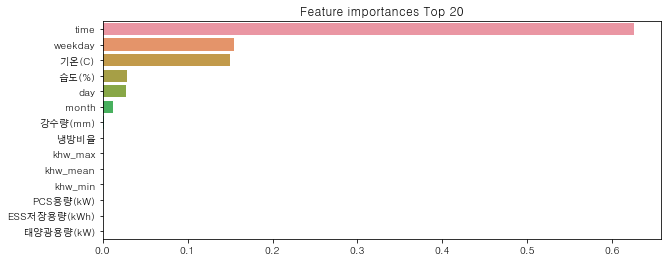

,건물번호,건물별_score
0,49.0,0.019739


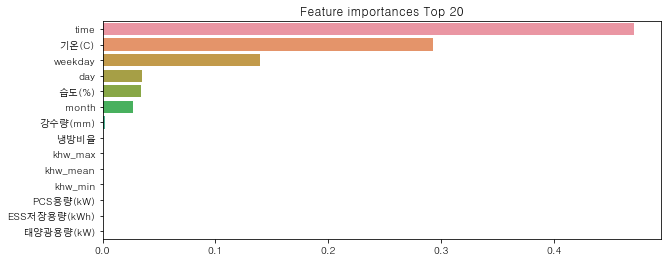

,건물번호,건물별_score
0,50.0,0.020648


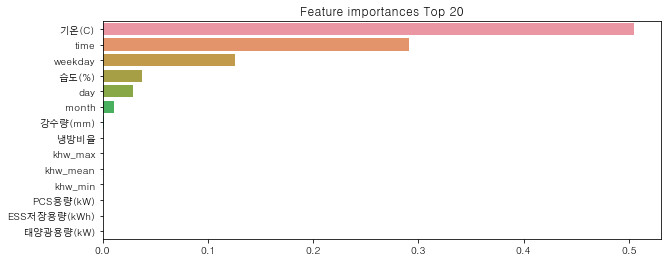

,건물번호,건물별_score
0,51.0,0.03009


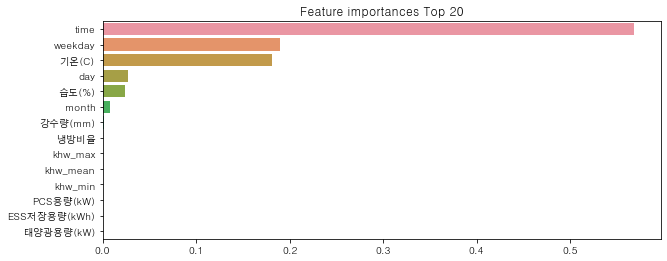

,건물번호,건물별_score
0,52.0,0.030573


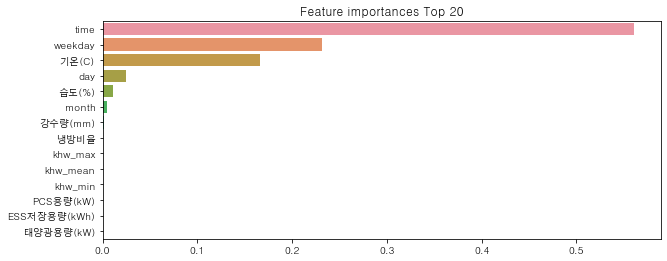

,건물번호,건물별_score
0,53.0,0.071277


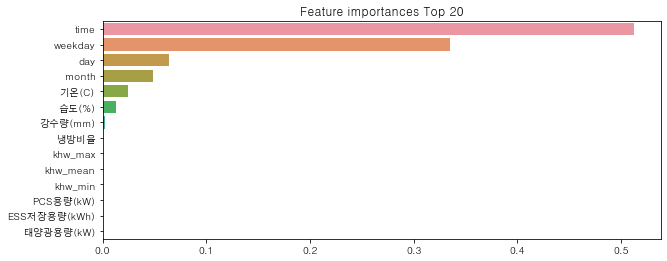

,건물번호,건물별_score
0,54.0,0.073135


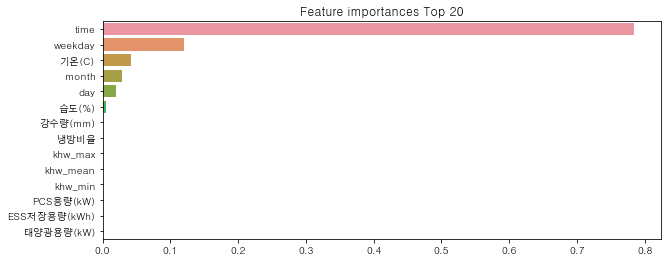

,건물번호,건물별_score
0,55.0,0.010564


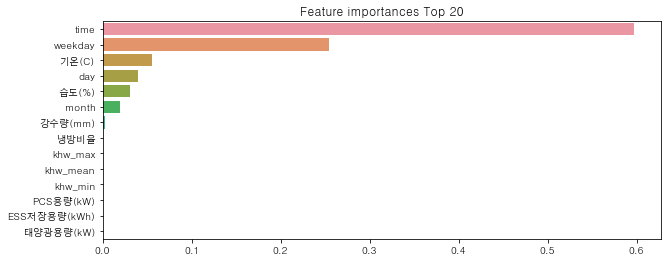

,건물번호,건물별_score
0,56.0,0.006108


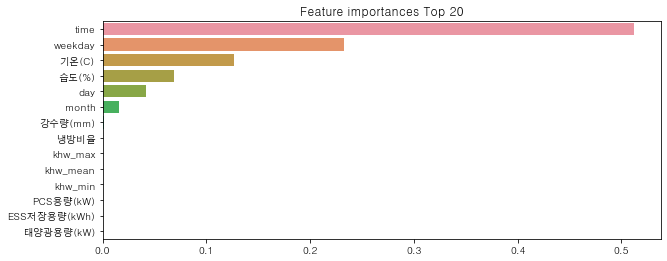

,건물번호,건물별_score
0,57.0,0.044499


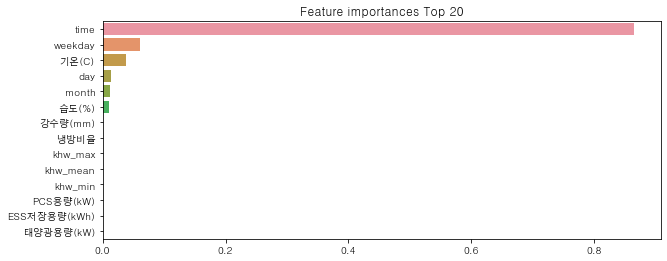

,건물번호,건물별_score
0,58.0,0.004158


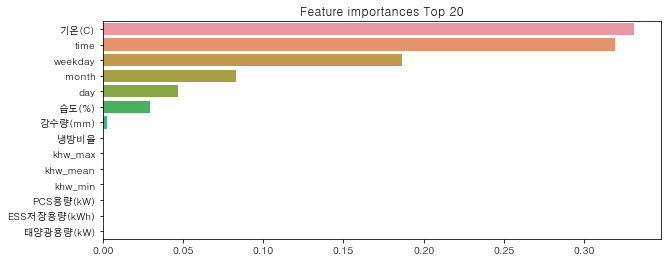

,건물번호,건물별_score
0,59.0,0.054333


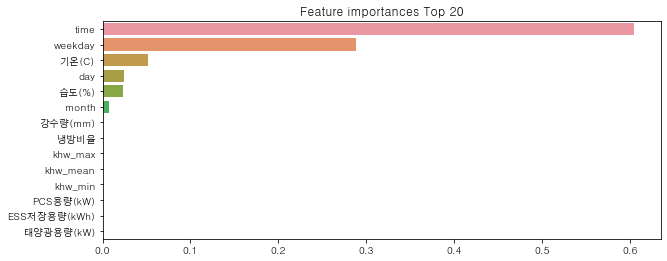

,건물번호,건물별_score
0,60.0,0.03661


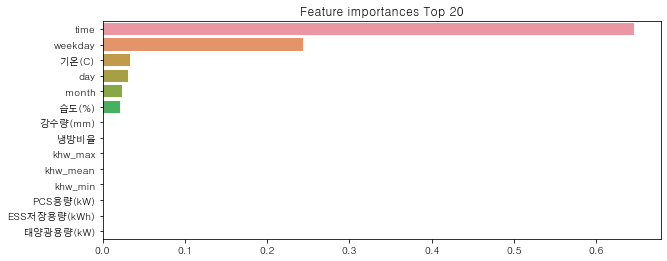

,건물번호,건물별_score
0,61.0,0.038997


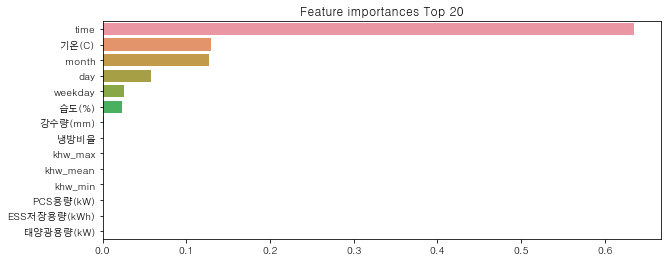

,건물번호,건물별_score
0,62.0,0.034658


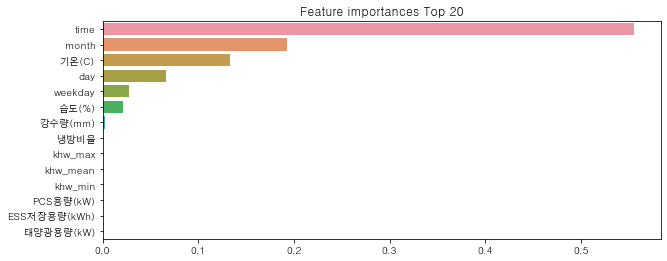

,건물번호,건물별_score
0,63.0,0.047092


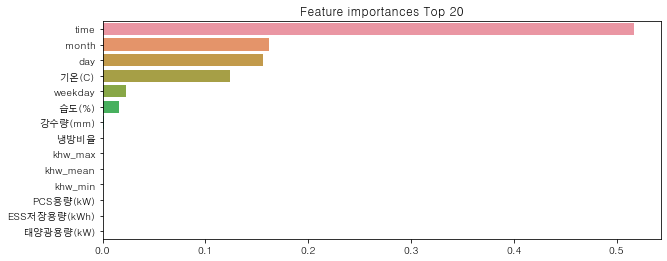

,건물번호,건물별_score
0,64.0,0.032742


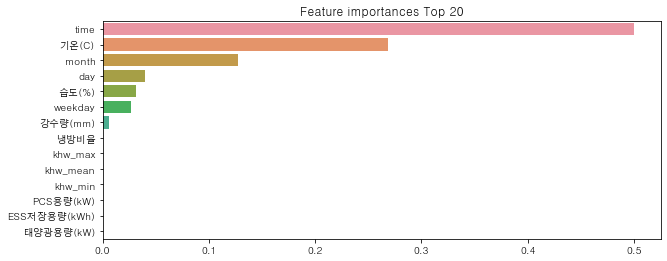

,건물번호,건물별_score
0,65.0,0.063042


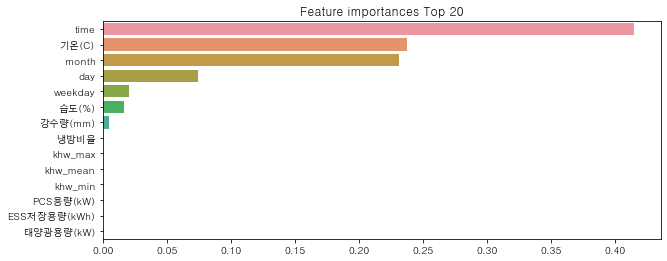

,건물번호,건물별_score
0,66.0,0.031677


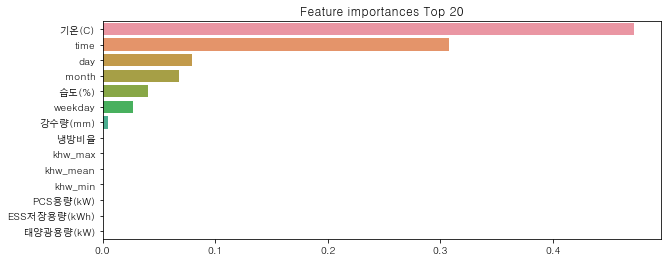

,건물번호,건물별_score
0,67.0,0.033478


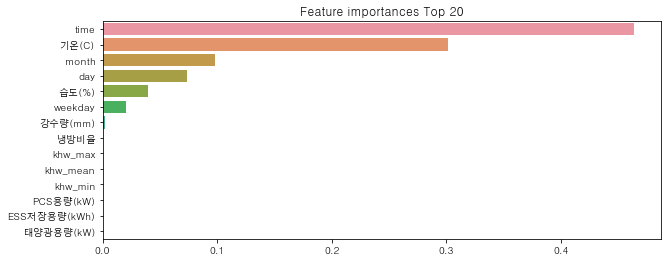

,건물번호,건물별_score
0,68.0,0.033717


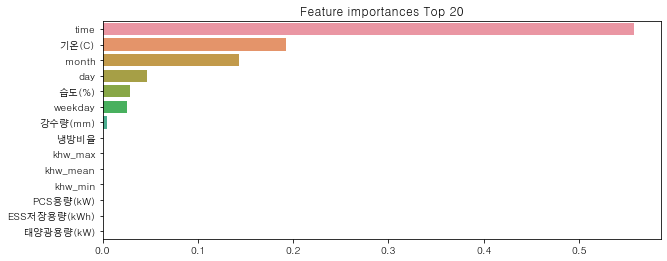

,건물번호,건물별_score
0,69.0,0.021327


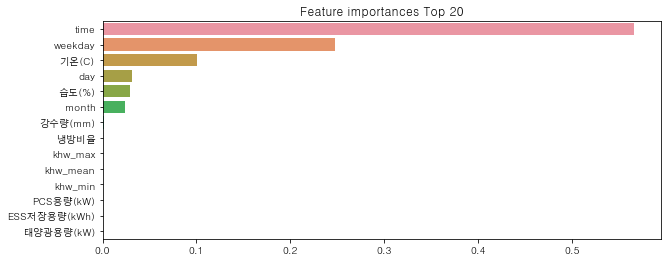

,건물번호,건물별_score
0,70.0,0.032567


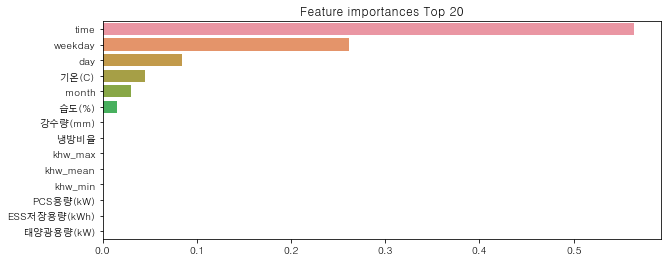

,건물번호,건물별_score
0,71.0,0.035492


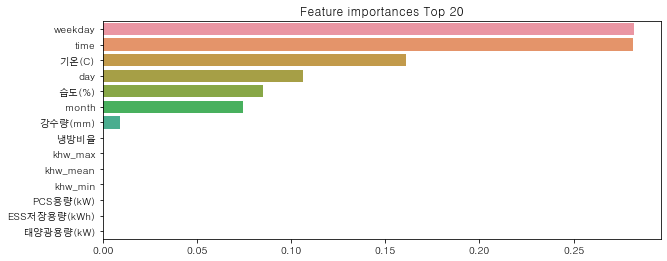

,건물번호,건물별_score
0,72.0,0.019954


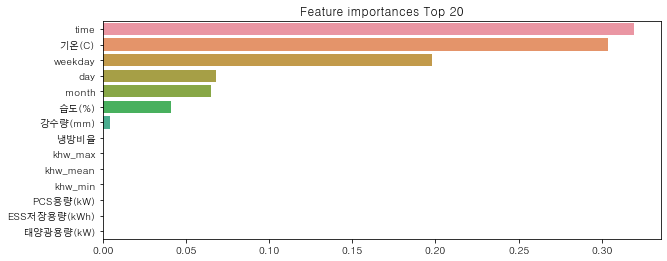

,건물번호,건물별_score
0,73.0,0.022275


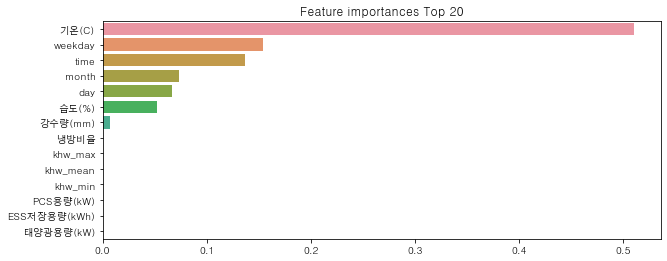

,건물번호,건물별_score
0,74.0,0.033944


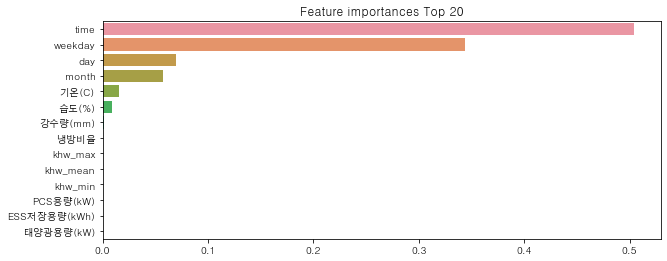

,건물번호,건물별_score
0,75.0,0.05546


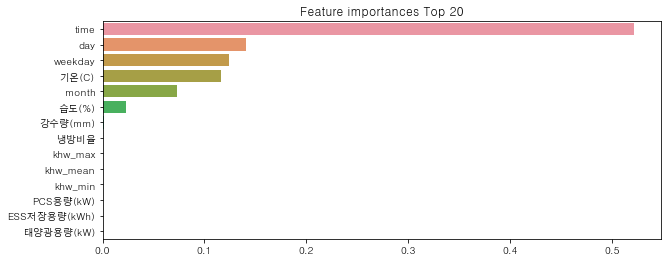

,건물번호,건물별_score
0,76.0,0.030394


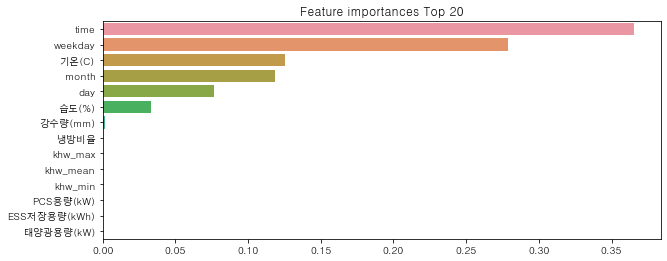

,건물번호,건물별_score
0,77.0,0.032302


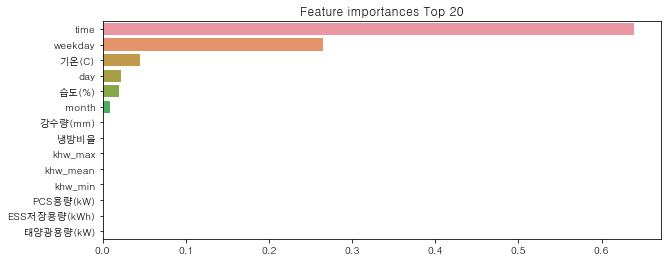

,건물번호,건물별_score
0,78.0,0.043949


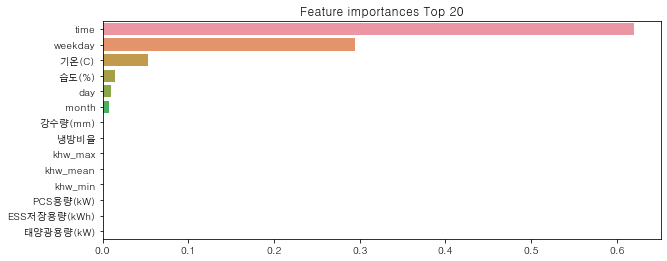

,건물번호,건물별_score
0,79.0,0.027642


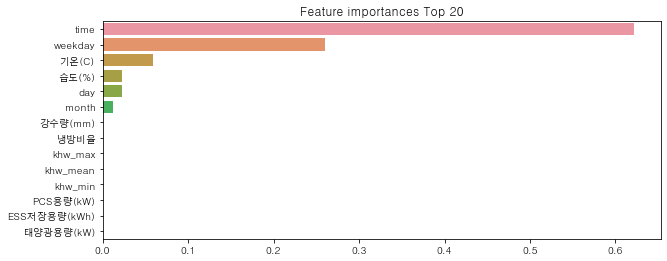

,건물번호,건물별_score
0,80.0,0.042752


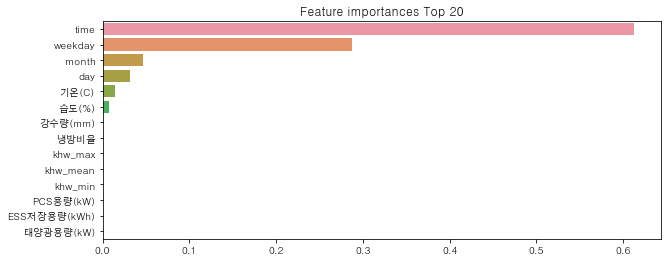

,건물번호,건물별_score
0,81.0,0.035396


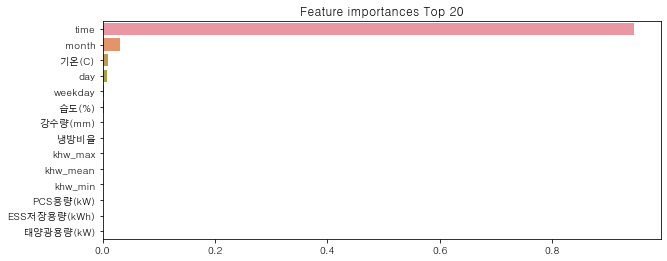

,건물번호,건물별_score
0,82.0,0.043646


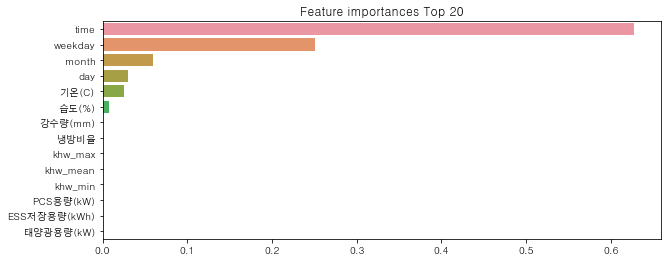

,건물번호,건물별_score
0,83.0,0.042279


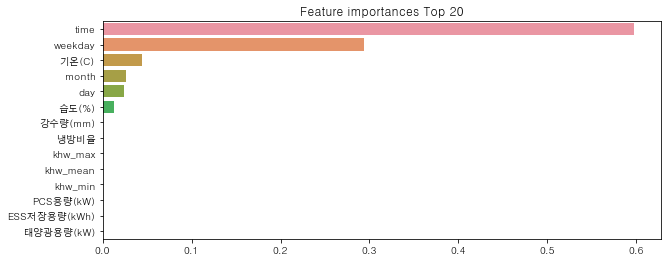

,건물번호,건물별_score
0,84.0,0.033985


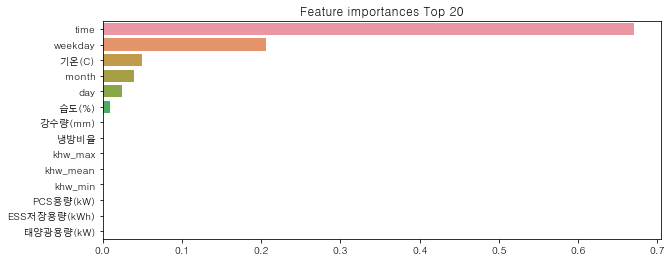

,건물번호,건물별_score
0,85.0,0.022027


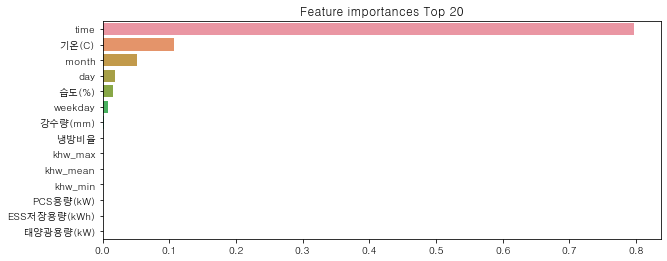

,건물번호,건물별_score
0,86.0,0.050738


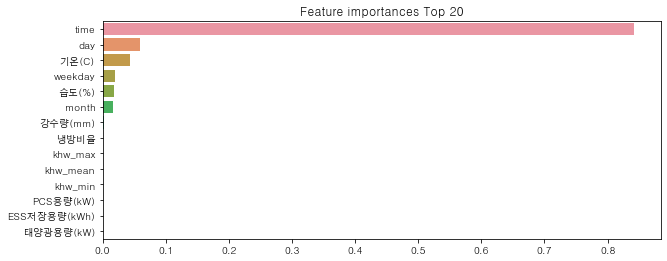

,건물번호,건물별_score
0,87.0,0.071075


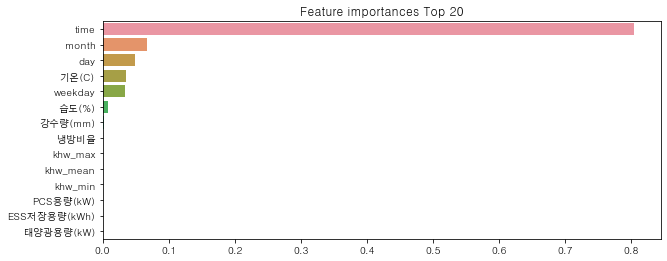

,건물번호,건물별_score
0,88.0,0.042173


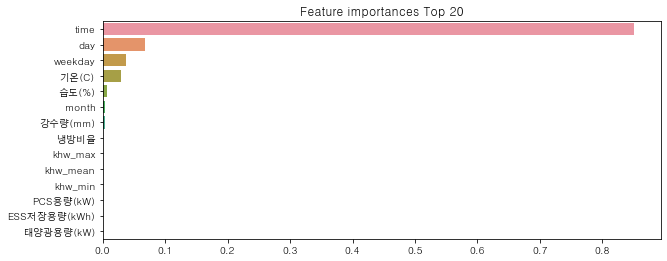

,건물번호,건물별_score
0,89.0,0.051117


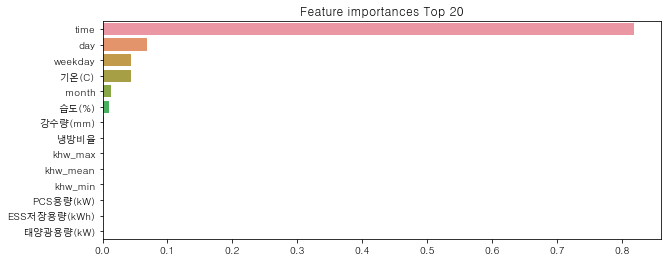

,건물번호,건물별_score
0,90.0,0.052342


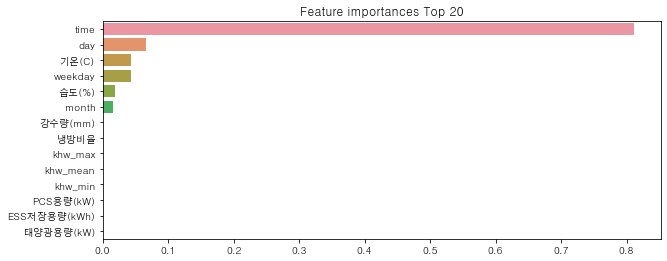

,건물번호,건물별_score
0,91.0,0.059575


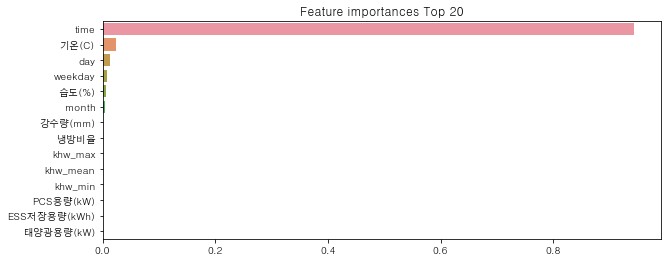

,건물번호,건물별_score
0,92.0,0.038579


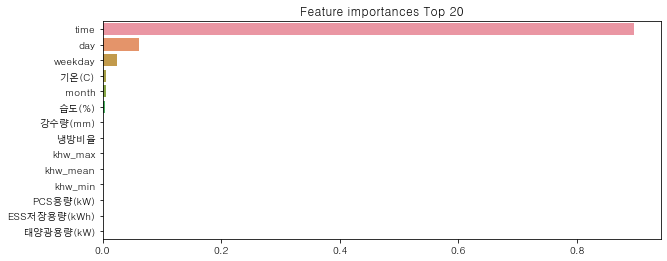

,건물번호,건물별_score
0,93.0,0.032377


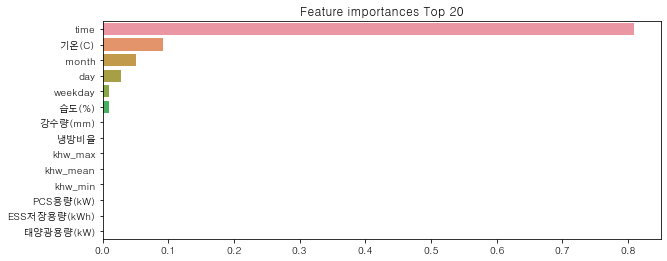

,건물번호,건물별_score
0,94.0,0.045621


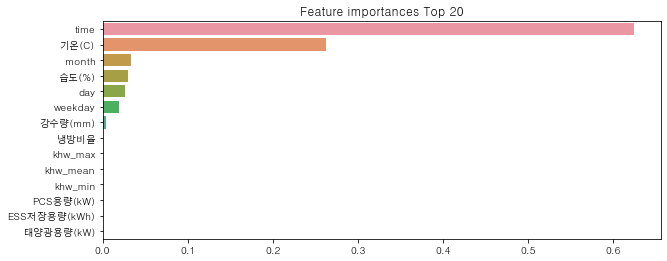

,건물번호,건물별_score
0,95.0,0.129411


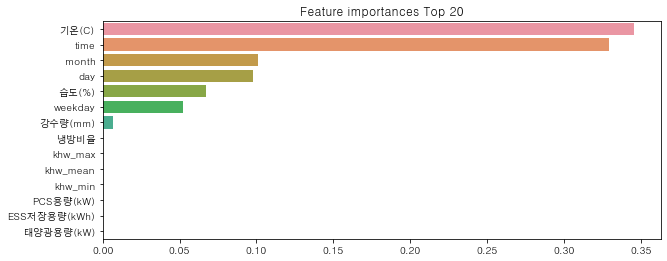

,건물번호,건물별_score
0,96.0,0.028885


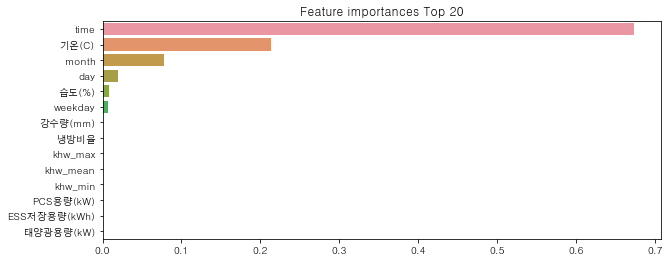

,건물번호,건물별_score
0,97.0,0.042118


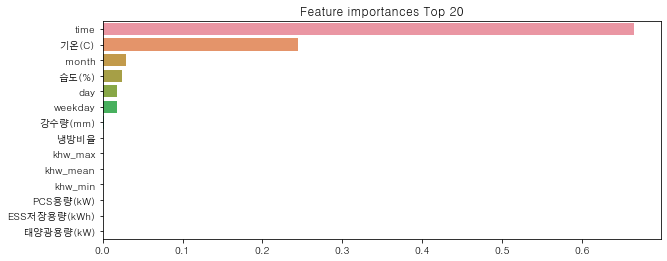

,건물번호,건물별_score
0,98.0,0.065543


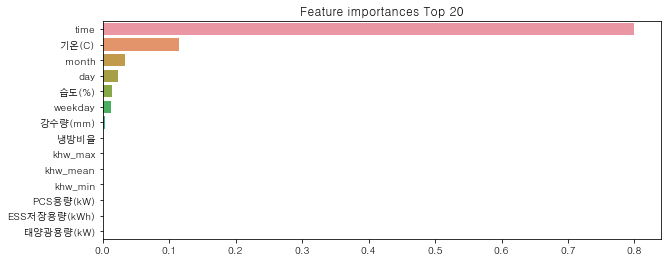

,건물번호,건물별_score
0,99.0,0.031991


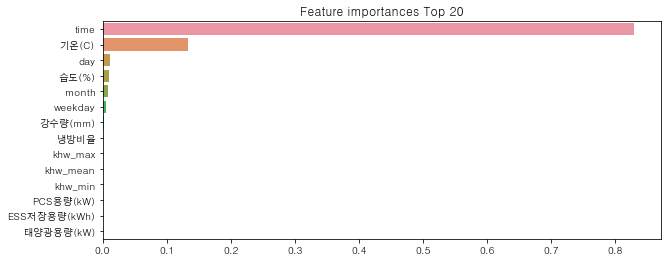

,건물번호,건물별_score
0,100.0,0.045955


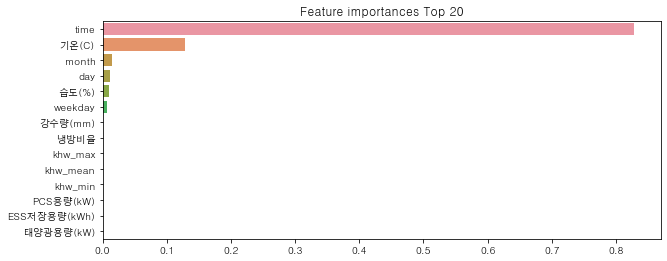


Wall time: 1min 17s


In [18]:
%%time 
metrics_bno = pd.DataFrame()
for i in train['건물번호'].unique():

    temp_X_train = X_train[X_train['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
        
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, mean_absolute_percentage_error(temp_y_test, y_preds)]).T
    temp.columns = ['건물번호', '건물별_score']
    metrics_bno = metrics_bno.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    print()

In [19]:
metrics_bno['건물번호'] = metrics_bno['건물번호'].astype(int)

In [20]:
metrics_bno = metrics_bno.merge(building_info[['건물유형','건물번호']], on=['건물번호'])

In [21]:
metrics = metrics_bno.merge(metrics_type, on=['건물유형'])
metrics[:2]

,건물번호,건물별_score,건물유형,유형별_score
0,1,0.052569,건물기타,0.0484948
1,2,0.058140,건물기타,0.0484948


In [22]:
# 유형보다 건물이 더 좋은 스코어를 가지는 건물번호 list
bno = metrics[metrics['건물별_score'] < metrics['유형별_score']]['건물번호'].values
len(bno), bno

(57,
 array([  4,   5,   6,   8,   9,  10,  11,  12,  13,  15,  22,  23,  24,
         25,  26,  27,  29,  32,  33,  35,  37,  39,  41,  42,  43,  44,
         45,  47,  48,  49,  50,  55,  56,  58,  60,  62,  64,  66,  67,
         68,  69,  72,  73,  76,  77,  79,  81,  84,  85,  88,  92,  93,
         94,  96,  97,  99, 100]))

In [23]:
metrics_type['유형별_score'].mean(), metrics_bno['건물별_score'].mean()

(0.037687918471134695, 0.038620361768516555)

In [24]:
# 가중 평균 
metrics_type['유형별_score'].mean() * ((100-len(bno))/100) + metrics_bno['건물별_score'].mean() * (len(bno)/100)

0.038219411150642355

In [25]:
metrics['score'] = metrics['유형별_score'] 
metrics.loc[metrics['건물번호'].isin(bno), 'score'] = metrics['건물별_score']

In [26]:
metrics['건물이낫다'] = metrics['건물별_score'] < metrics['유형별_score']

In [27]:
metrics.to_excel('오차큰것부터_20230724-2.xlsx')

## Inference & Submit

In [28]:
%%time
result_type = pd.DataFrame()
for i in train['건물유형'].unique():
    
    temp_X_train = train[train['건물유형'] == i].drop(['건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물유형'] == i].drop(['건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_type = result_type.append( pd.concat([test[test['건물유형'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_유형별']).reset_index()], axis=1) )
    
result_type.shape    

Wall time: 1min 9s


(16800, 21)

In [29]:
%%time
result_bno = pd.DataFrame()
for i in train['건물번호'].unique():
    
    temp_X_train = train[train['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_bno = result_bno.append( pd.concat([test[test['건물번호'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_건물별']).reset_index()], axis=1) )
    
result_bno.shape    

Wall time: 1min 9s


(16800, 21)

In [30]:
result = result_type[['num_date_time','건물번호','answer_유형별']].merge(result_bno[['num_date_time','건물번호','answer_건물별']], on=['num_date_time','건물번호'])
result['answer'] = result['answer_유형별'] 
result.loc[result['건물번호'].isin(bno), 'answer'] = result['answer_건물별']
result[['num_date_time','answer']].to_csv('20230724-2.csv', index=False)